In [1]:
using LinearAlgebra
using Plots
using MultivariateStats, StatsPlots
using Distributions
using DelimitedFiles
using DataFrames
using CSV

# Unscented Kalman Filtering on a Kinematic Bicycle

## Helper Functions

In [2]:
# f, Kinematic bicycle with teleporting steering
function dynamics(x, u, params)
    v, l = params
    px, py, θ = x
    δ = u[1]
    ẋ = [v*cos(θ);
         v*sin(θ);
         v*tan(δ) / l]
    return ẋ
end

dynamics (generic function with 1 method)

In [3]:
# Approximately integrate dynamics over a timestep dt to get a discrete update function
function rk4(xₖ, uₖ, params, dt)
    k1 = dynamics(xₖ, uₖ, params)
    k2 = dynamics(xₖ + k1*dt/2, uₖ, params)
    k3 = dynamics(xₖ + k2*dt/2, uₖ, params)
    k4 = dynamics(xₖ + k3*dt, uₖ, params)

    xₖ₊₁ = xₖ + dt * (k1 + 2k2 + 2k3 + k4) / 6
    return xₖ₊₁
end

rk4 (generic function with 1 method)

In [4]:
# Given a mean and covariance in N-dimensional space, generate 2N+1 weighted points
# with the given weighted mean and weighted covariance
function generate_sigma_points(x̂, Σ)
    Nx = length(x̂)
    A = sqrt(Σ)
    σ = [zeros(Nx) for j in 1:(2Nx+1)]
    W = zeros(2Nx+1)
    W[1] = 1/3

    σ[1] .= x̂

     for j in 1:Nx
        σ[1+j] .= @. x̂ + √(Nx / (1 - W[1])) * A[:,j] 
     end
 
     for j in 1:Nx
        σ[1+Nx+j] .= @. x̂ - √(Nx / (1 - W[1])) * A[:,j] 
     end
 
    W[2:end] .= (1- W[1])/(2Nx)
    
    return σ, W
end

generate_sigma_points (generic function with 1 method)

In [5]:
# maps vector in state space to vector in measurement space
# g, "GPS" measurement of positions
function measurement(x)
    y = x[1:2]
    return y
end

measurement (generic function with 1 method)

## Predict and Update

In [6]:
# Given a state estimate and covariance, apply nonlinear dynamics over dt to sigma points
# and calculate a new state estimate and covariance
function ukf_predict(x̂ₖ, Σₖ, Q, uₖ, dt, params)
    Nx = length(x̂ₖ)
    σ, W = generate_sigma_points(x̂ₖ, Σₖ)

    for k in 1:lastindex(σ)
        σ[k] .= rk4(σ[k], uₖ, params, dt)
    end 

    x̂ₖ₊₁ = zeros(Nx)
    Σₖ₊₁ = zeros(Nx, Nx)

    for k in 1:lastindex(σ)
        x̂ₖ₊₁ .+= W[k].* σ[k]
    end
    for k in 1:lastindex(σ)
        Σₖ₊₁ .+= W[k].* ((σ[k] - x̂ₖ₊₁) * (σ[k] - x̂ₖ₊₁)')
    end

    Σₖ₊₁ .+= Q

    return x̂ₖ₊₁, Σₖ₊₁
end

ukf_predict (generic function with 1 method)

In [7]:
# Given a state estimate, covariance of the state estimate, measurement and covariance of the measurement,
# apply the measurement function to sigma points,
# calculate the mean and covariance in measurement space, then use this to calculate the Kalman gain, 
# then use the gain and measurement to calculate the updated state estimate and covariance.
function ukf_update(x̂, Σ, y, R)
    Nx = length(x̂)
    Ny = length(y)
    σ, W = generate_sigma_points(x̂, Σ)
    z = [zeros(Ny) for _ in σ]

    for j in 1:lastindex(σ)
        z[j] = measurement(σ[j])
    end 

    ẑ = zeros(Ny)
    S = zeros(Ny, Ny)
    Cxz = zeros(Nx, Ny)

    for k in 1:lastindex(z)
        ẑ .+= W[k].* z[k]
    end
    for k in 1:lastindex(z)
        S .+= W[k].* (z[k] - ẑ) * (z[k] - ẑ)'
        Cxz .+= W[k] .* (σ[k] - x̂) * (z[k] - ẑ)'
    end
    S .+= R

    K = Cxz * inv(S)

    x̂ₖ₊₁ = x̂ + K * (y - ẑ)
    Σₖ₊₁ = Σ - K * S * K'
    return x̂ₖ₊₁, Σₖ₊₁
end

ukf_update (generic function with 1 method)

## Testing
using the filter on a simulated scenario

### Defining properties of the scenario
system parameters and covariances

In [8]:
# System parameters

l = 1.0 # Wheelbase, (m)
v = 4.0 # Velocity, (m/s)
params = v, l

(4.0, 1.0)

In [9]:
# Covariances. Remember, these are in squared units. To get an idea of the 
# corresponding 95% confidence interval, take the square root and multiply by ~2.

Σ0 = diagm(ones(3)) # Initial estimate covariance for the filter
R = diagm([0.5; 0.5]) # Sensor covariances (m^2, m^2)
Q = diagm([1e-4; 1e-4; 1e-6]) # Process covariances (m^2, m^2, rad^2) 
                              # ^ the process covariances are timestep size dependent

3×3 Matrix{Float64}:
 0.0001  0.0     0.0
 0.0     0.0001  0.0
 0.0     0.0     1.0e-6

### Generating State Data
a list of "reality/truth" state data; where the buggy actually is for the sake of this scenario

In [10]:
# Simulation parameters

# Timesteps
dt = 0.01
Nk = 500
Dts = dt*ones(Nk)
t = cumsum(Dts) .- dt

# Initial conditions and inputs
x0 = [0; 0; 0]
U = [[[10/180*π] for k in 1:(Nk÷2)]; [[-10/180*π] for k in 1:(Nk÷2)]];

In [11]:
function simulate_deterministic(Dt, U, x0, params)
    Nk = length(Dt)
    Nx = length(x0)
    @assert Nk == length(U)
    X = [zeros(Nx) for k in 1:Nk]
    X[1] .= x0

    for k in 1:(Nk-1)
        X[k+1] = rk4(X[k], U[k], params, Dt[k])
    end

    return X
end

simulate_deterministic (generic function with 1 method)

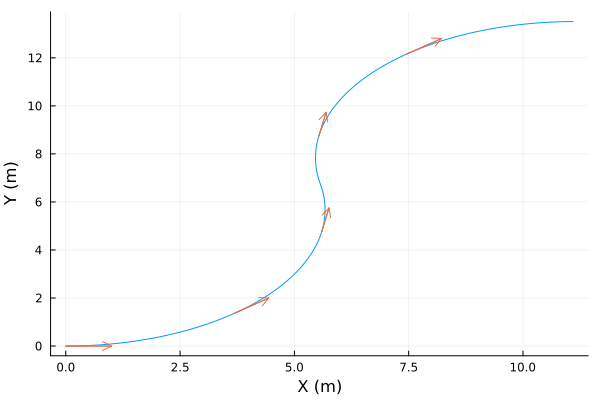

In [12]:
X = simulate_deterministic(Dts, U, x0, params)
plot([x[1] for x in X], [x[2] for x  in X], xlabel="X (m)", ylabel="Y (m)", label=nothing)
quiver!([x[1] for x in X[1:100:end]], [x[2] for x  in X[1:100:end]], quiver=([cos(x[3]) for x in X[1:100:end]], [sin(x[3]) for x  in X[1:100:end]]))

### Writing to `reality.csv` and `input.csv`

In [13]:
# Outputing reality state data to CSV file:
# timestamps, and state parameters at each timestamp
filepath = "reality.csv"
header = "timestamp,pos_x,pos_y,heading\n"
open(filepath, "w") do file
  write(file, header)
end

for i in 1:length(t)
  s = string(t[i]) * ","
  s = s * string(X[i][1]) * ","
  s = s * string(X[i][2]) * ","
  s = s * string(X[i][3]) * "\n"
  open(filepath, "a") do file
    write(file, s)
  end
end
# Outputing input data to CSV file:
# timestamps, and input parameters at each timestamp
filepath = "input.csv"
header = "timestamp,input\n"
open(filepath, "w") do file
  write(file, header)
end

for i in 1:length(t)
  s = string(t[i]) * ","
  s = s * string(U[i][1]) * "\n"
  open(filepath, "a") do file
    write(file, s)
  end
end

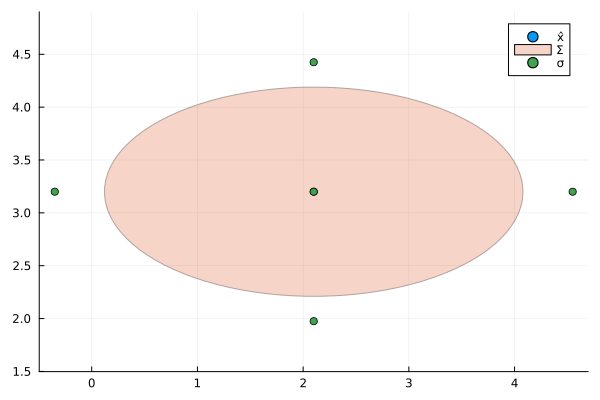

In [14]:
# Visualization to sanity check sigma points for some 2D gaussian
x̂ = [2.1; 3.2]
P = diagm([2.0; 0.5])

σs, Ws = generate_sigma_points(x̂, P)

scatter([x̂[1]], [x̂[2]], label="x̂", aspect_ratio=:equal)
covellipse!(x̂[1:2], 1.96 * P[1:2,1:2], label="Σ")
scatter!([σ[1] for σ in σs],[σ[2] for σ in σs], label="σ")

### Using the UKF

In [15]:
# Simulate a non-deterministic process with process covariance Q and measurement covariance R,
# and with an Unscented Kalman Filter applied
function simulate_uk_filter(Dt, U, x0, Σ0, Q, R, params)
    Nk = length(Dt)
    Nx = length(x0)
    Ny = size(R, 1)
    @assert Nk == length(U)

    X = [zeros(Nx) for _ in 1:Nk]
    Xhat = [zeros(Nx) for _ in 1:Nk]
    Σs = [zeros(Nx,Nx) for _ in 1:Nk]
    Y = [zeros(Ny) for _ in 1:Nk]

    distQ = MvNormal(zeros(size(Q,1)), Q)
    distR = MvNormal(zeros(size(R,1)), R)

    X[1] .= x0
    Xhat[1] .=  x0
    Y[1] .=  measurement(x0)
    Σs[1] .= Σ0

    for k in 1:(Nk-1)
        # Simulate noisy dynamics and measurement
        X[k+1] .= rk4(X[k], U[k], params, Dt[k]) .+ rand(distQ)
        Y[k+1] .= measurement(X[k+1]) .+ rand(distR)

        # Run Unscented Kalman Filter
        x̂, Σ = ukf_predict(Xhat[k], Σs[k], Q, U[k], Dt[k], params)
        x̂, Σ = ukf_update(x̂, Σ, Y[k+1], R)
        Xhat[k+1] .= x̂
        Σs[k+1] .= Σ
    end

    return X, Σs, Y, Xhat
end

simulate_uk_filter (generic function with 1 method)

In [16]:
X, Σs, Y, Xhat = simulate_uk_filter(Dts, U, x0, Σ0, Q, R, params)

([[0.0, 0.0, 0.0], [0.03927574205694717, 0.009725219942062416, 0.00605981341154149], [0.056061555630060794, 0.016461426556857058, 0.01199587370570922], [0.08909526464716995, 0.025059051244138937, 0.01942745575981128], [0.12852639880890357, 0.024749988293384588, 0.02698346481724833], [0.16209645297933506, 0.02246113785815019, 0.03434370768548535], [0.19376601953076955, 0.038412072586880466, 0.04292149081086823], [0.2400523734268524, 0.03678996944046853, 0.0505452590975791], [0.2753854586343942, 0.03674304757341744, 0.05851134489633142], [0.3106040104289372, 0.036196093173769366, 0.06379523008296176]  …  [10.46687156488642, 13.403508434834531, 0.09105273560941335], [10.506219507019704, 13.430353455479544, 0.08600424148319341], [10.538313316495573, 13.446761577537027, 0.08035638162673385], [10.581923673653689, 13.483739343561489, 0.07105735103031871], [10.625287306275112, 13.484136917251051, 0.06398769687125254], [10.654862312394865, 13.487615046523949, 0.056787865214819114], [10.70564440

### Outputting `measure.csv`, `filter.csv` and `covariance.csv`

In [17]:
# Outputing (simulated) measured data to CSV file:
# timestamps, and measured parameters at each timestamp
filepath = "measure.csv"
header = "timestamp,pos_x,pos_y\n"
open(filepath, "w") do file
  write(file, header)
end

for i in 1:length(t)
  s = string(t[i]) * ","
  s = s * string(Y[i][1]) * ","
  s = s * string(Y[i][2]) * "\n"
  open(filepath, "a") do file
    write(file, s)
  end
end

# Outputing filtered data to CSV file:
# timestamps, and filtered state parameters at each timestamp
filepath = "filter.csv"
header = "timestamp,pos_x,pos_y,heading\n"
open(filepath, "w") do file
  write(file, header)
end

for i in 1:length(t)
  s = string(t[i]) * ","
  s = s * string(Xhat[i][1]) * ","
  s = s * string(Xhat[i][2]) * ","
  s = s * string(Xhat[i][3]) * "\n"
  open(filepath, "a") do file
    write(file, s)
  end
end

# Outputing estimated covariance matrices data to CSV file:
# timestamps, and row-major matrix values at each timestamp
filepath = "covariance.csv"
header = "timestamp,c1,c2,c3,c4,c5,c6,c7,c8,c9\n"
open(filepath, "w") do file
  write(file, header)
end

for i in 1:length(t)
  s = string(t[i]) * ","
  s = s * string(Σs[i][1,1]) * ","
  s = s * string(Σs[i][1,2]) * ","
  s = s * string(Σs[i][1,3]) * ","
  s = s * string(Σs[i][2,1]) * ","
  s = s * string(Σs[i][2,2]) * ","
  s = s * string(Σs[i][2,3]) * ","
  s = s * string(Σs[i][3,1]) * ","
  s = s * string(Σs[i][3,2]) * ","
  s = s * string(Σs[i][3,3]) * "\n"
  open(filepath, "a") do file
    write(file, s)
  end
end

### Visualizations

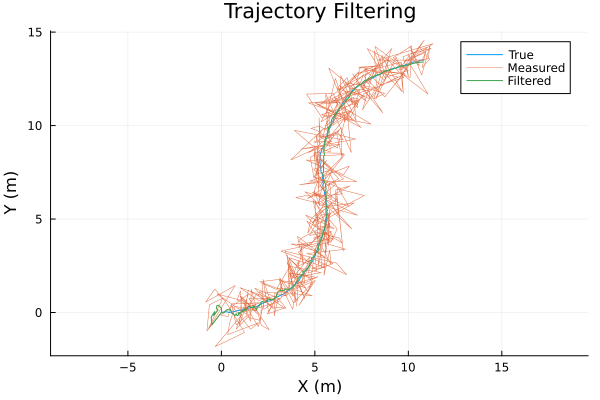

In [18]:
# Let's see how the filter does on position estimation

plot(title="Trajectory Filtering", xlabel="X (m)", ylabel="Y (m)", aspect_ratio=:equal)
plot!([x[1] for x in X], [x[2] for x in X], label="True")
plot!([y[1] for y in Y], [y[2] for y in Y], label="Measured", linewidth=0.5)
plot!([x[1] for x in Xhat], [x[2] for x in Xhat], label="Filtered")

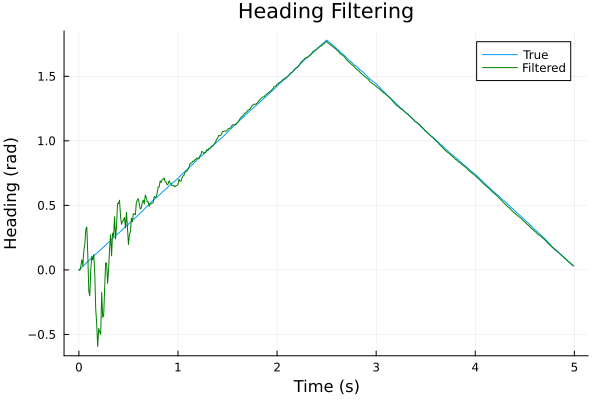

In [19]:
# Remember, we aren't measuring the heading, only a noisy position, 
# but the filter is able to use this information to converge to
# a good estimate of the heading over time.

plot(title="Heading Filtering", xlabel="Time (s)", ylabel="Heading (rad)")
plot!(t, [x[3] for x in X], label="True")
plot!(t, [x[3] for x in Xhat], label="Filtered", color="green")

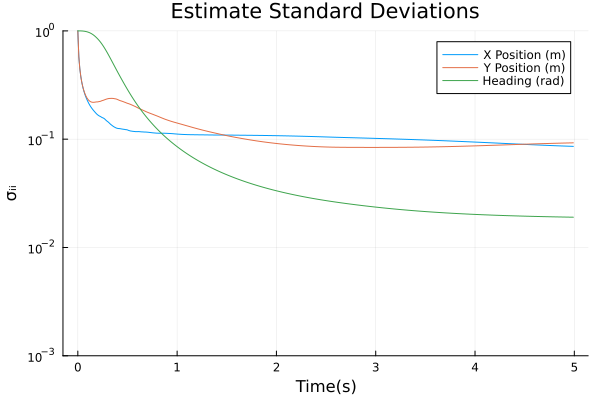

In [20]:
# And let's see how the filter's confidence in its estimate evolves over time

plot(title="Estimate Standard Deviations", xlabel="Time(s)", ylabel="σᵢᵢ", yscale=:log10, ylim=(1e-3, 1))
plot!(t, [√(σ²[1,1]) for σ² in Σs], label="X Position (m)")
plot!(t, [√(σ²[2,2]) for σ² in Σs], label="Y Position (m)")
plot!(t, [√(σ²[3,3]) for σ² in Σs], label="Heading (rad)")

# Comparing C++ Teensy Implementation Results

In [21]:
nand_filter_traj_df = DataFrame(CSV.File("NAND-filter.csv"))

Row,timestamp,pos_x,pos_y,heading
,Float64,Float64,Float64,Float64
1,0.0,0.008172,2.9e-5,0.007053
2,0.01,0.019609,-0.652943,-0.04523
3,0.02,-0.00558,-0.288779,0.035687
4,0.03,0.133764,-0.28818,0.042349
5,0.04,0.121709,-0.234439,0.078384
6,0.05,0.065724,-0.24744,0.076495
7,0.06,0.099121,-0.137238,0.189803
8,0.07,0.087764,-0.110401,0.227356
9,0.08,0.159286,-0.066987,0.280501


## Julia vs. Teesny Error from Truth

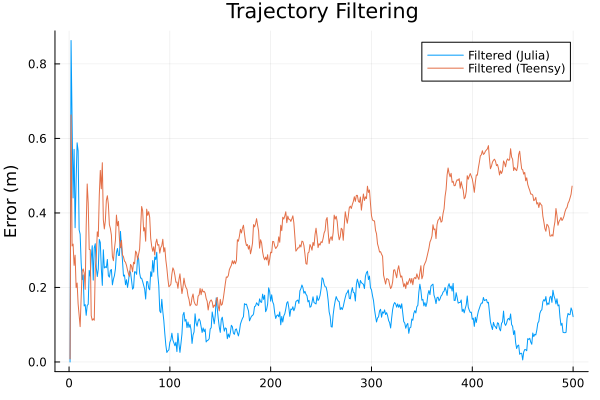

In [22]:
px = nand_filter_traj_df[:,"pos_x"]
py = nand_filter_traj_df[:,"pos_y"]

plot(title="Trajectory Filtering", xlabel="", ylabel="Error (m)")
# plot!([x[1] for x in X], [x[2] for x in X], label="True")
plot!([norm(x[1:2] - xhat[1:2]) for (xhat,x) in zip(Xhat, X)], label="Filtered (Julia)")
plot!([norm(x[1:2] - [px; py]) for (px,py,x) in zip(px, py, X)], label="Filtered (Teensy)")

## Truth, Julia, Teensy Position Plot

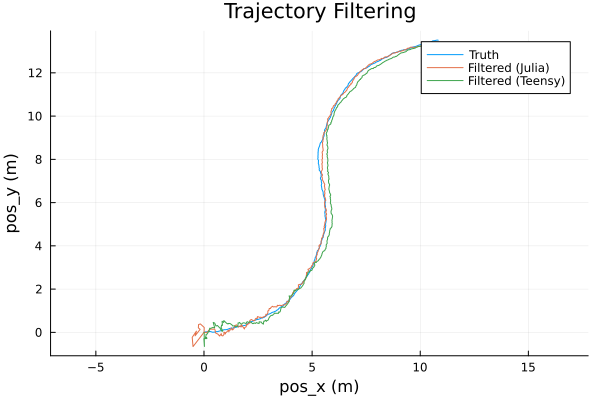

In [23]:
px = nand_filter_traj_df[:,"pos_x"]
py = nand_filter_traj_df[:,"pos_y"]

plot(title="Trajectory Filtering", xlabel="pos_x (m)", ylabel="pos_y (m)", aspect_ratio=:equal)
plot!([x[1] for x in X], [x[2] for x in X], label="Truth")
plot!([x[1] for x in Xhat], [x[2] for x in Xhat], label="Filtered (Julia)")
plot!([x for x in px], [x for x in py], label="Filtered (Teensy)")